# NLP Essay Organization Scorer

This project seeks to use NLP tools on a set of middle and high school essays to classify them based on their level of organization. The data was provided in a Kaggle competition by the Hewlett Foundation seven years ago. The essays were hand-graded by more than one rater for standardized testing. I will be using spacy to tokenize the essays of interest and clustering and supervised learning models to attempt to predict their organization scores.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/Python'

/content/gdrive/My Drive/Python


In [3]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans, MeanShift, SpectralClustering
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

!python -m spacy download en


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [4]:
# Read in our first ten essays from the json file we have saved them to
data = pd.read_csv('training_set_rel3.tsv', 
                   delimiter='\t', 
                   encoding='latin_1', 
                   error_bad_lines=False, 
                   warn_bad_lines=True)

# Determine how many essays there are by set
data.groupby('essay_set').count()

,essay_id,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_set,,,,,,,,,,,,,,,,,,,,,
1,1783,1783,1783,1783,0,1783,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800,1800,1800,1800,0,1800,1800,1800,1800,0,...,0,0,0,0,0,0,0,0,0,0
3,1726,1726,1726,1726,0,1726,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1770,1770,1770,1770,0,1770,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1805,1805,1805,1805,0,1805,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1800,1800,1800,1800,0,1800,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1569,1569,1569,1569,0,1569,0,0,0,1569,...,1569,1569,0,0,0,0,0,0,0,0
8,723,723,723,723,128,723,0,0,0,723,...,723,723,723,723,128,128,128,128,128,128


In [5]:
# Get just the essays in the sets that have a distinct organization score
org_score_data = data[data['essay_set'].isin([7,8])]

# Essays 7 & 8 have organization scores at trait 2,
# rename them to something simpler
org_score_data.rename(columns={'rater1_trait2': 'org1', 
                               'rater2_trait2': 'org2', 
                               'rater3_trait2': 'org3'}, inplace=True)

org_score_data['mean_org_score'] = 0
org_score_data = org_score_data.loc[:, ['essay_id', 
                                        'essay_set',
                                        'essay',
                                        'org1',
                                        'org2',
                                        'mean_org_score']]

# Calculate the mean org score
for i in range(len(org_score_data)):
    org_score_data.iloc[i, -1] = np.mean([org_score_data.iloc[i, -2],
                                          org_score_data.iloc[i, -3]])
    
org_score_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,essay_id,essay_set,essay,org1,org2,mean_org_score
10684,17834,7,Patience is when your waiting .I was patience ...,2.0,2.0,2.0
10685,17836,7,"I am not a patience person, like I cant sit i...",1.0,2.0,1.5
10686,17837,7,One day I was at basketball practice and I was...,2.0,2.0,2.0
10687,17838,7,I going to write about a time when I went to t...,2.0,2.0,2.0
10688,17839,7,It can be very hard for somebody to be patient...,2.0,2.0,2.0


In [6]:
# Fix punctuation errors that interfere with sentence splitting
for i in range(len(org_score_data.essay)):
  
  org_score_data.iloc[i, 2]  = re.sub(r'(?<=[\.\,\?\!])(?=[^\s])', 
                                      ' ',
                                      org_score_data.iloc[i, 2])

org_score_data.head()

,essay_id,essay_set,essay,org1,org2,mean_org_score
10684,17834,7,Patience is when your waiting . I was patience...,2.0,2.0,2.0
10685,17836,7,"I am not a patience person, like I cant sit i...",1.0,2.0,1.5
10686,17837,7,One day I was at basketball practice and I was...,2.0,2.0,2.0
10687,17838,7,I going to write about a time when I went to t...,2.0,2.0,2.0
10688,17839,7,It can be very hard for somebody to be patient...,2.0,2.0,2.0


In [0]:
# Restructure the data into rows for each sentence in the essay
sentence_data = []
nlp = spacy.load('en')

for i in range(len(org_score_data)):
    essay_id = org_score_data.essay_id.tolist()[i]
    essay_set = org_score_data.essay_set.tolist()[i]
    org_1 = org_score_data.org1.tolist()[i]
    org_2 = org_score_data.org2.tolist()[i]
    org_score = org_score_data.mean_org_score.tolist()[i]
    sentences = list(nlp(org_score_data.essay.tolist()[i]).sents)
    for j in range(len(sentences)):
        sentence_data.append([essay_id, essay_set, j, sentences[j], org_1, org_2, org_score])


In [8]:
# Create the sentence-wise data frame
sent_df = pd.DataFrame(sentence_data, columns=['essay_id', 'essay_set', 'sentence_num', 
                                               'sentence', 'org_1', 'org_2', 'org_score'])
sent_df.head()

,essay_id,essay_set,sentence_num,sentence,org_1,org_2,org_score
0,17834,7,0,"(Patience, is, when, your, waiting, .)",2.0,2.0,2.0
1,17834,7,1,"(I, was, patience, when, in, line, waiting, fo...",2.0,2.0,2.0
2,17834,7,2,"(I, didnt)",2.0,2.0,2.0
3,17834,7,3,"(c, ut, any, one, to, eat, .)",2.0,2.0,2.0
4,17834,7,4,"(I, was, standing, and, waiting, for, my, turn...",2.0,2.0,2.0


In [9]:
seven_df = sent_df.loc[sent_df['essay_set']==7]
eight_df = sent_df.loc[sent_df['essay_set']==8]

seven_df['org_score'] = seven_df['org_score'].apply(lambda x: int((x + 1) * 3) -2)
eight_df['org_score'] = eight_df['org_score'] * 2

sent_df = pd.concat([seven_df, eight_df])
sent_df['org_score'] = sent_df['org_score'].astype('int64')
sent_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,essay_id,essay_set,sentence_num,sentence,org_1,org_2,org_score
0,17834,7,0,"(Patience, is, when, your, waiting, .)",2.0,2.0,7
1,17834,7,1,"(I, was, patience, when, in, line, waiting, fo...",2.0,2.0,7
2,17834,7,2,"(I, didnt)",2.0,2.0,7
3,17834,7,3,"(c, ut, any, one, to, eat, .)",2.0,2.0,7
4,17834,7,4,"(I, was, standing, and, waiting, for, my, turn...",2.0,2.0,7


In [0]:
sent_df['raw_score'] = 0

In [11]:
raw_score_dict = {}
cluster_dict = {}
for e in sent_df['essay_id'].unique():
  cluster_dict[e] = {}
  essay = sent_df.loc[sent_df['essay_id']==e]
  sn = range(essay.sentence_num.tolist()[-1])
  raw_org_score = []
  for i in sn:
    sent_score = np.sum([essay.sentence.tolist()[i].similarity(essay.sentence.tolist()[j]) / (np.log(abs(j-i))+1) for j in sn if j != i])
    raw_org_score.append(sent_score)
    cluster_dict[e].update({str(i)+str(j): essay.sentence.tolist()[i].similarity(essay.sentence.tolist()[j]) for j in sn if j != i and abs(j-i) < 6})
  raw_score_dict[e] = np.mean(raw_org_score)
  if e % 100  == 0:
    print(raw_score_dict[e])

2.83844261694476
5.241092900540041
5.00265312351701


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.112137371522585
3.426767638273424
3.743459342049491
4.25425215278264
1.4664523412597466
2.9733815679828033
4.784537747086869
4.2335798038379675
3.5695029582873303
3.9540579878822895
3.06744730209008
1.3098006682378902
2.9682959301951213
6.588401874371875
6.363647820232217
4.3208511829399
9.365658133327328
10.261635002554742
8.64766591499461


In [12]:
cluster_df = pd.DataFrame(cluster_dict)
cluster_df.fillna(cluster_df.mean(), inplace=True)
cluster_df = cluster_df.T
cluster_df.head()

,01,02,03,04,05,10,1011,1012,1013,1014,...,9594,9596,96,9691,9692,9693,9694,9695,97,98
17834,0.637271,0.122946,0.212327,0.561724,0.462888,0.637271,0.441983,0.472919,0.472919,0.472919,...,0.472919,0.472919,0.439273,0.472919,0.472919,0.472919,0.472919,0.472919,0.461008,0.372455
17836,0.734469,0.743172,0.535095,0.409800,0.555344,0.734469,0.555344,0.555344,0.555344,0.555344,...,0.555344,0.555344,0.555344,0.555344,0.555344,0.555344,0.555344,0.555344,0.555344,0.555344
17837,0.501412,0.568725,0.635602,0.767329,0.649697,0.501412,0.570150,0.499382,0.499382,0.499382,...,0.499382,0.499382,0.479013,0.499382,0.499382,0.499382,0.499382,0.499382,0.422788,0.307651
17838,0.734580,0.365541,0.530736,0.532862,0.719456,0.734580,0.842731,0.218887,0.509203,0.509203,...,0.509203,0.509203,0.641746,0.509203,0.509203,0.509203,0.509203,0.509203,0.557339,0.699424
17839,0.453823,0.747733,0.746139,0.635583,0.244928,0.453823,0.529632,0.529632,0.529632,0.529632,...,0.529632,0.529632,0.554842,0.529632,0.529632,0.529632,0.529632,0.529632,0.649634,0.739864


In [13]:
sent_df['raw_score'] = sent_df['essay_id'].replace(raw_score_dict, inplace=False)
sent_df.tail()

,essay_id,essay_set,sentence_num,sentence,org_1,org_2,org_score,raw_score
54826,21633,8,24,"(Learning, that, at, any, moment, I, can, laug...",4.0,4.0,8,6.248613
54827,21633,8,25,"(Even, if, there, is, no, joke, being, told, ,...",4.0,4.0,8,6.248613
54828,21633,8,26,"(Most, people, would, probably, look, a, me, i...",4.0,4.0,8,6.248613
54829,21633,8,27,"(Laughing, relieves, stress, ,, makes, other, ...",4.0,4.0,8,6.248613
54830,21633,8,28,"(I, have, finally, learned, that, even, with, ...",4.0,4.0,8,6.248613


In [0]:
score_df = sent_df.groupby('essay_id')[['org_score', 'raw_score']].mean()

In [15]:
cluster_indices = np.where(cluster_df.isna())
drop_indices = [x for x in np.unique(cluster_indices[0])]
drop_values = [cluster_df.index.values.tolist()[i] for i in drop_indices]
drop_values

[17992,
 18088,
 18109,
 18149,
 18152,
 18167,
 18348,
 18426,
 18481,
 18496,
 18504,
 18535,
 18885,
 18958,
 19010,
 19131,
 19149,
 19358,
 19472,
 19492,
 19497,
 21389,
 21619]

In [0]:
cluster_df = cluster_df.drop(drop_values, axis=0)
score_df =  score_df.drop(drop_values, axis=0)

In [0]:
cluster_train, cluster_test, cluster_labels_train, cluster_labels_test = train_test_split(cluster_df, score_df['org_score'])
kmc = KMeans(n_clusters=11).fit(cluster_train)

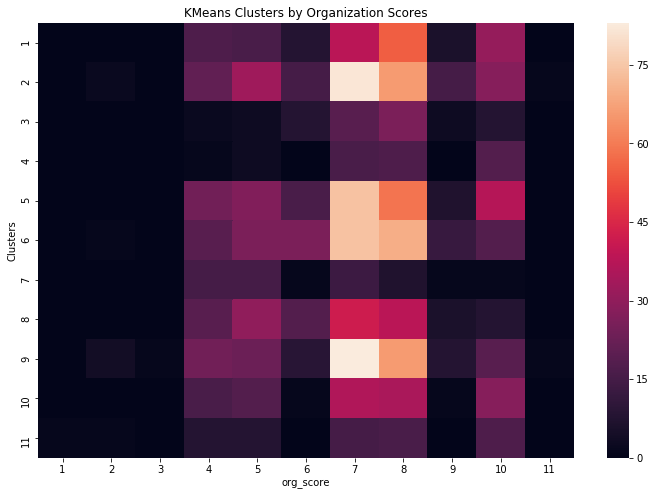

In [18]:
cm = pd.crosstab(kmc.labels_+1, cluster_labels_train)
plt.figure(figsize=(12,8))
sns.heatmap(cm)
plt.title('KMeans Clusters by Organization Scores')
plt.ylabel('Clusters')
plt.show()

In [19]:
cm

org_score,1,2,3,4,5,6,7,8,9,10,11
row_0,,,,,,,,,,,
1,0,0,0,17,16,8,38,55,6,31,0
2,0,2,0,21,33,15,82,66,15,28,1
3,0,0,0,2,3,8,19,26,3,8,0
4,0,0,0,1,3,0,16,17,0,18,0
5,0,0,0,24,27,16,74,59,7,37,0
6,0,1,0,19,26,26,74,70,12,18,0
7,0,0,0,15,15,1,13,7,1,1,0
8,0,0,0,19,30,18,42,38,6,8,0
9,0,4,1,24,23,9,83,66,8,19,1


In [20]:
rc_dict  = {8:6, 5:7, 4:9, 1:4, 7:3, 2:5, 0:8, 10:1}

acc = np.sum([cm.iloc[k, v] for k,v in rc_dict.items()]) / np.sum(cm.sum())
print('Clustering model train accuracy: {}'.format(acc))

Clustering model train accuracy: 0.15108759553204


In [21]:
cluster_pred = kmc.predict(cluster_test)
cluster_test_cm = pd.crosstab(cluster_pred, cluster_labels_test)
cluster_test_cm

org_score,2,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,
0,0,5,9,1,15,11,2,7,0,0
1,0,9,7,4,32,31,4,12,0,0
2,0,0,1,1,4,3,1,2,0,0
3,0,0,1,0,5,3,1,2,0,0
4,0,4,15,4,22,22,7,8,0,1
5,1,11,8,7,29,27,3,6,0,0
6,0,4,0,0,8,1,0,1,0,0
7,0,6,12,3,16,15,6,1,1,0
8,0,3,8,5,30,28,3,9,0,0


In [22]:
clrtst_rc_dict = {1:4, 8:5, 4:2, 5:1, 7:3, 9:7, 0:6}

clrtst_acc = np.sum([cluster_test_cm.iloc[k, v] 
                     for k,v in clrtst_rc_dict.items()]) / np.sum(cluster_test_cm.sum())
print('Clustering model test accuracy: {}'.format(clrtst_acc))

Clustering model test accuracy: 0.17253521126760563


In [0]:
bw = estimate_bandwidth(cluster_train)
ms = MeanShift(bandwidth=bw).fit(cluster_train)

In [25]:
ms_pred = ms.predict(cluster_test)
ms_test_cm = pd.crosstab(ms_pred, cluster_labels_test)
ms_test_cm

org_score,2,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,
0,1,41,59,24,154,134,23,44,1,1
13,0,0,0,0,0,2,0,0,0,0
21,0,0,4,0,7,3,1,4,0,0
30,0,0,0,0,4,4,0,1,0,0
32,0,1,1,0,0,0,0,0,0,0
35,0,0,0,0,0,2,0,0,0,0
58,0,0,0,0,1,0,0,1,0,0
71,0,0,0,0,0,0,1,0,0,0
76,0,1,1,0,2,1,1,1,0,0


In [27]:
ms_test_cm.iloc[0, 4] / np.sum(ms_test_cm.sum())

0.2711267605633803

In [0]:
sc = SpectralClustering(n_clusters=11).fit(cluster_train)

In [31]:
sc_pred = sc.fit_predict(cluster_test)
sc_test_cm = pd.crosstab(sc_pred, cluster_labels_test)
sc_test_cm

org_score,2,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,
0,1,39,52,24,138,126,24,39,1,1
1,0,1,0,0,0,2,0,2,0,0
2,0,0,0,0,1,1,0,1,0,0
3,0,2,3,2,10,6,1,4,0,0
4,0,2,1,0,0,1,0,0,0,0
5,0,0,2,1,3,2,0,0,0,0
6,0,0,0,0,4,3,0,2,0,0
7,0,0,2,0,2,2,1,1,0,0
8,0,0,1,0,2,1,0,2,0,0


In [32]:
160 / np.sum(sc_test_cm.sum())

0.28169014084507044

In [33]:
lgr = LogisticRegression(solver='lbfgs', C=0.2, multi_class='multinomial')

X_train, X_test, y_train, y_test = train_test_split(
    np.array(score_df['raw_score']).reshape(-1, 1), 
    score_df['org_score'], test_size=0.3)

lgr.fit(X_train, y_train)

pred = lgr.predict(X_test)
lgr_cm = pd.crosstab(pred, y_test)

lgr.score(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.3992443324937028

In [34]:
lgr_acc = []
for row in lgr_cm.index.tolist():
  lgr_acc.append(lgr_cm.loc[row, row])
lgr_acc = np.sum(lgr_acc) / np.sum(lgr_cm.sum())
lgr_acc

0.3568281938325991

In [35]:
rfc  = RandomForestClassifier(n_estimators=100, criterion='entropy')
rfc.fit(X_train, y_train)

pred = rfc.predict(X_test)
rfc_cm = pd.crosstab(pred, y_test)

rfc.score(X_train, y_train)

1.0

In [36]:
rfc_acc = []
for row in rfc_cm.index.tolist():
  if row in rfc_cm.columns.tolist():
    rfc_acc.append(rfc_cm.loc[row, row])
rfc_acc = np.sum(rfc_acc) / np.sum(rfc_cm.sum())
rfc_acc

0.3069016152716593

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100)
gbc.fit(X_train, y_train)

pred = gbc.predict(X_test)
gbc_cm = pd.crosstab(pred, y_test)

gbc.score(X_train, y_train)

0.6580604534005038

In [38]:
gbc_acc = []
for row in gbc_cm.index.tolist():
  if row in gbc_cm.columns.tolist():
    gbc_acc.append(gbc_cm.loc[row, row])
gbc_acc = np.sum(gbc_acc) / np.sum(gbc_cm.sum())
gbc_acc

0.30837004405286345

# Write-up

## Corpus

My area of interest is in using NLP to help lighten the work load for teacher. With that in mind, I wanted to select a corpus of essays that I could attempt to model a grade for. Since scraping a large set of essays was beyond the scope and timeframe I had for this project, I decided to hone my first phase on a corpus of essays that was already collected, organized, and labelled from an old Kaggle competition. 

This essay dataset came from the Hewlett Foundation Automated Essay Scoring Competition from 7 years ago. The data had named entities replaced with an anonymous tag (e.g. @LOCATION1) for the purposes of reducing bias in scoring of the essays in the standardized tests. There were 8 sets of essays based on different prompts and from different standardized tests, but I chose to focus on two sets (sets 7 & 8) that had component scores for organization. 

## Hypothesis

From my experience as a writer and a teacher, I hypothesized that the sentences of an essay would follow a pattern of similarity. That is, the first sentence should be most like the second sentence, less like the third sentence, and even less like the fourth sentence. If one were to visualize this as a heatmap of sentence similarity, It should look like a gradual dimming of diagonals with the brightest spots on the index diagonal (1,1; 2,2; 3,3; etc.) because a sentence is exactly similar to itself, but adjacent sentences should be nearly as bright and sentences furthest from each other should be dimmest (having the least correlation). I sought to quantify this hypothesis in a scoring function that I would then use to score essays and feed those scores into my model.

One caveat for the generalizability of this model: all of these essays are single paragraph essays writtent by 7th or 10th grade students. To adapt this model for a mutli-paragraph essay, I would need to account for the fact that each paragraph is a self-contained entity where supporting details should be more closely tied to the topic sentence than a closer-by-distance sentence in the next paragraph. And all topic sentences should be closely related to the thesis statement, regardless of their distance.

## Scoring Function
I knew I wanted to take the similarity between sentences to determine how organized the essay was, but I also knew I need to account for the distance between sentences. For each sentence, I decided to give the sentence a score based on the sum of its similarities to all other sentences divided by the natural log of its distance from those sentences. This ensured that its similarity to more distant sentences counted, but not quite as much as its similarity to nearby sentences. Finally, the essay received an organization score that was the mean of all the sentence-level organization scores. This allowed for the essays not to be penalized based on their length. For future iterations with mutli-paragraph essays, I would like to make a weight based on the average length of paragraphs compared to the total length of the essay.

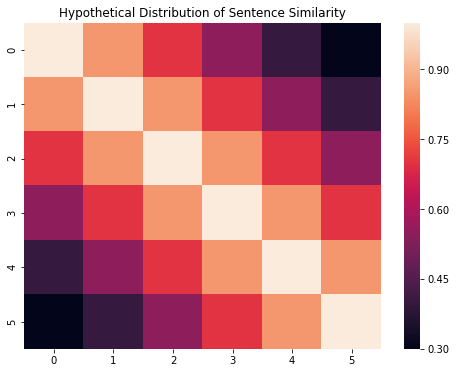

In [39]:
hypothesis = [[1, 0.85, 0.7, 0.55, 0.4, 0.3], 
              [0.85, 1, 0.85, 0.7, 0.55, 0.4], 
              [0.7, 0.85, 1, 0.85, 0.7, 0.55], 
              [0.55, 0.7, 0.85, 1, 0.85, 0.7],
              [0.4, 0.55, 0.7, 0.85, 1, 0.85],
              [0.3, 0.4, 0.55, 0.7, 0.85, 1]]
plt.figure(figsize=(8,6))
sns.heatmap(hypothesis)
plt.title('Hypothetical Distribution of Sentence Similarity')
plt.show()

## Preparing the Data for Modeling
### Decoding the Essays
The dataset was encoded in a way that made it difficult to properly decode with the python data science toolkit. Some bytes were left encoded, but I felt that there were not so many as to interfere significantly with the similarity scoring of sentences.

### Cleaning the Text
I considered running spell check and other automated text cleaning functions to ensure that words were properly spelled and could be matched with their counterpart words in other sentences more readily. The scope and timeframe of this project did not allow for an in-depth exploration into whether those spell check methods would have made a difference, so I have relegated them to future iterations of this project. I have, however, found all instances of  punctuation being immediately followed by a word instead of a space and added in that space to facilitate sentence delineation. 

### Tokenization
There were several models I considered for tokenization of the sentences in the essays before comparison for similarity. For the sake of building the simplest model first, I chose the native attribute `doc.sents` for a doc tokenized by spacy. This attribute has a built-in method `sent.similiarity(text)` that allows for easy extraction of similarity scores between sentences. In future iterations, I intend to compare this sentence tokenization method to comparable methods from gensim's word2vec and doc2vec.

### Feature Engineering
In order to get features for my supervised learning model, I needed to implement the scoring function that I outlined above. I iterated over the sentences, taking the similarity scores with all the other sentences, divided by the natural logarithm of their distance, and summed those to create a sentence score. Then I took the mean of all sentence scores to create the raw organization score. 

For the labels, I needed to get the average score of the two raters, but my final labels needed to be integers. Also, essay set 7 and set 8 were graded on two different scales (0-4, 1-6). First, I split the data frame based on the essay set, then I added an offset to the zero-indexed mean score, multiplied by 3, and subtracted another offset to get values between 1 and 10. I multiplied the mean score of the other essay set by 2 to get values between 2 and 12. 

For the clustering model features, I took the similarity scores of every sentence pair in the essay that was within 6 sentences of each other. The 6 sentence maximum  distance was chosen as an arbitrary stopping point to maintain the relevance of the features and prevent the feature engineering algorithm from running too long. To fill the null features for essays shorter than the longest essay, I imputed the mean. This assumes that if the student were asked to continue writing until they reached the maximum number of sentences in the essay set, they would continue to write in a style as organized as they had to the point they stopped.

## Clustering
### K-Means
K-Means clustering assumes clusters that are isotropic, have similar variance, and roughly equal observations. These assumptions are not met by the sentence similarity data and lead to a poor model that over classifies the dominant classes and neglects the other. This is not the best clustering model to benchmark my supervised models against

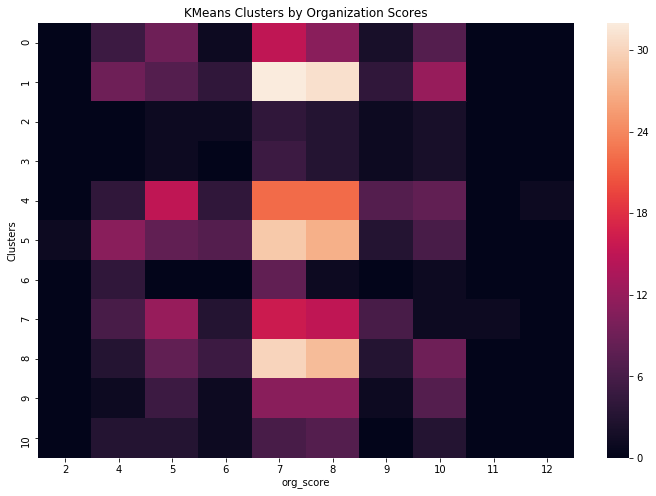

In [40]:
plt.figure(figsize=(12,8))
sns.heatmap(cluster_test_cm)
plt.title('KMeans Clusters by Organization Scores')
plt.ylabel('Clusters')
plt.show()

### Mean Shift
Mean Shift clusters got granular with the clustering beyond the majority class. It determined that there should be way more clusters than there are possible organization scores, but all of the clusters except one were relatively empty. This was not a good choice for a clustering model.

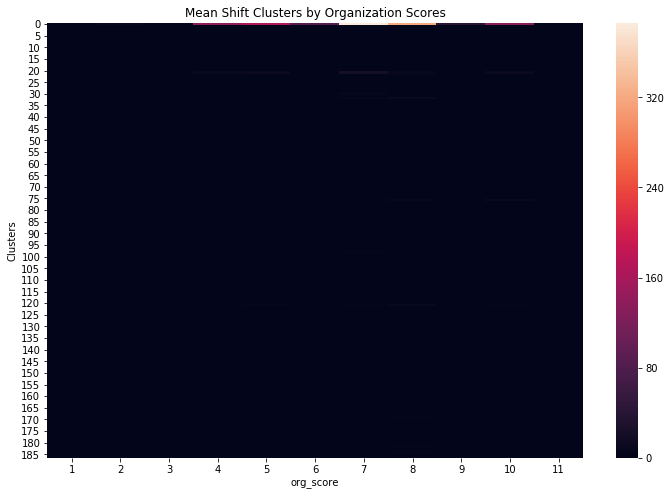

In [24]:
ms_cm = pd.crosstab(ms.labels_, cluster_labels_train)
plt.figure(figsize=(12,8))
sns.heatmap(ms_cm)
plt.title('Mean Shift Clusters by Organization Scores')
plt.ylabel('Clusters')
plt.show()

### Spectral Clustering

Spectral Clustering performed almost as terribly as Mean Shift clustering, except for the fact that I told it how many clusters to look for. Both models were able to get near 30% accuracy just by predicting the majority class, but they were not in the ballpark on detecting any of the other classes. Despite not meeting the model assumptions, K-Means was still the best performing clustering model for classes other then the dominant class.

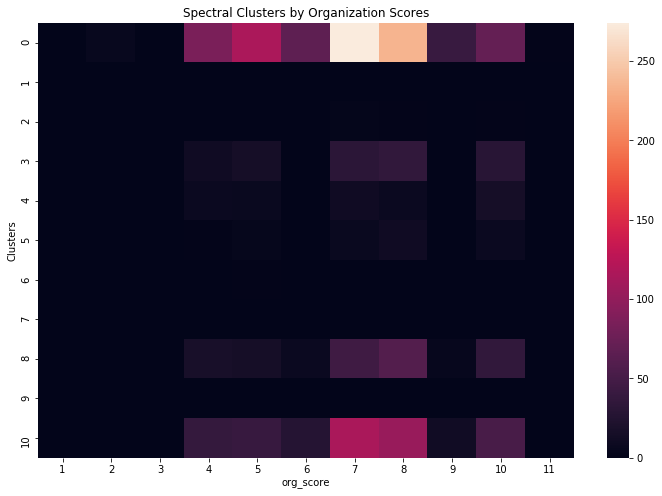

In [29]:
sc_cm = pd.crosstab(sc.labels_, cluster_labels_train)
plt.figure(figsize=(12,8))
sns.heatmap(sc_cm)
plt.title('Spectral Clusters by Organization Scores')
plt.ylabel('Clusters')
plt.show()

## Supervised Models
###Logisitic Regression
The multinomial logistic regression model assumes low multi-collinearity and feature values that map one-to-one on labels. While the first assumption is met by the presence of only one feature, the second assumption is demonstrably broken as visualized in the scatter plot below . As shown in the scatter plot, the majority of essays are scored 6-8. The heatmap below shows that the logistic regression model gets most of its 39% accuracy from predicting the two majority classes. It makes an attempt at predicting the score 4, which I would interpret as the most dominant class to be tightly clustered on a range of lower scores. This would not be my model of choice under these circumstances.

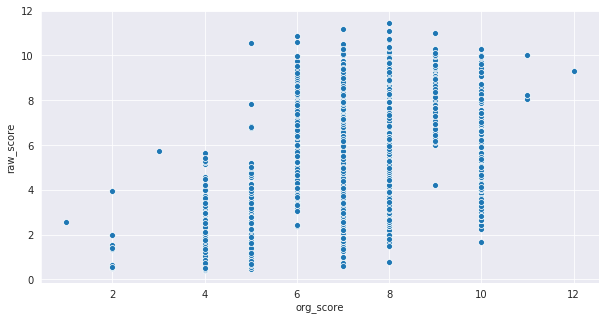

In [41]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))
sns.scatterplot(x='org_score', y='raw_score', data=score_df)
plt.show()


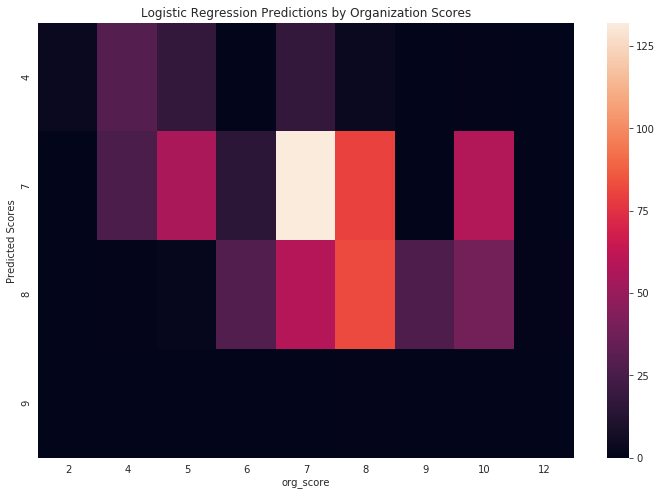

In [42]:
plt.figure(figsize=(12,8))
sns.heatmap(lgr_cm)
plt.title('Logistic Regression Predictions by Organization Scores')
plt.ylabel('Predicted Scores')
plt.show()

### Random Forest Classifier
The Random Forest model severely overfit the training data (99+%), but achieved just 29% accuracy on the test set. Of the supervised learning classifiers, though, it would be my model of choice under the current circumstances. This model tried to classify some of the minority classes. The heatmap below resembles the heatmap for the K-Means clustering model, but more disperse. I believe that with a more finely tuned scoring function and some more features derived from sound reasoning, the random forest classifier would be able to outperform the clustering model. 

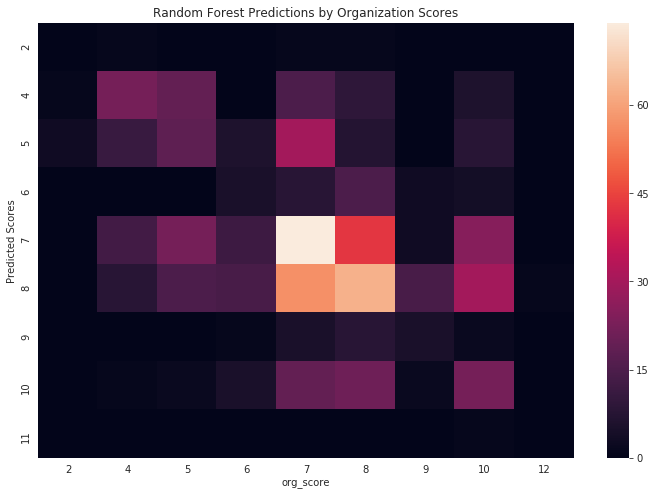

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(rfc_cm)
plt.title('Random Forest Predictions by Organization Scores')
plt.ylabel('Predicted Scores')
plt.show()

### Gradient Boosting Classifier
The Gradient Boosting model did not overfit as much as the Random Forest model, and it performed better in test accuracy, but it did so by sacrificing minority classes for the majority classes. I will continue compare it to the other classifiers as I iterate over this project with new features.

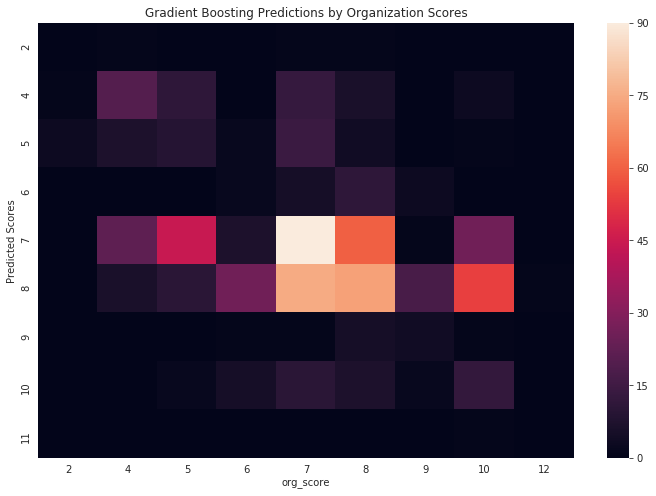

In [44]:
plt.figure(figsize=(12,8))
sns.heatmap(gbc_cm)
plt.title('Gradient Boosting Predictions by Organization Scores')
plt.ylabel('Predicted Scores')
plt.show()

## Conclusion and Next Steps

The first iteration of the organization grading model did not meet my expectations. However, there is much room for improvement within the project.

### Text Data
I could improve on the project by collecting more labelled data and cleaning the data that I have. The current data needs to be explored to see what other errors are hiding in the essays aside from the ones I have seen in the head and tails of the data frames (undecoded bytes, rectangle where apostrophes should be, spaces in the middle of words.) I intend to use different spell checkers that are available to find words that match known misspellings in the vocabulary and try permutations of surrounding characters for words that do not exist within the vocabulary. 

### Features

#### A New Scoring Function
The scoring function that I created changed a few times during the course of this project and will likely change many more before I am satisfied with its performance and the reasoning behind it. The first, simple tweak will be comparing the performance of the function if sentence similarities are divided by the distance instead of the natural logarithm of the distance. Still, I want there to be more features within the feature set and will continue to think about whether one number for the essay organization score is sufficient or whether there should be more scores included within the set.

#### Other Text Features
I always intended for the next iteration of this project to include a comparison of different models for tokenizing sentences. Some of those models will include reducing the sentence to its lemmas before creating the sentence vector. I want to explore reasonable ways in which parts of speech, dependencies, and named entities could play a role in the feature set. Named entities will require some extra legwork since all named entities have been anonymized in the essay sets I was using up to this point. Finally, some text summarization can be used to determine a thesis for the essay and a topic sentence for each paragraph, to begin to determine how closely linked all sentences in a paragraph are to their topic sentence and how well the topic sentences relate to the thesis. 

### Models
I will do research on the models that have the best performance for this type of problem and the range of parameters that work best. Then, I will perform GridSearchCV to determine the best  model with the best parameters. I will also look into pretrained neural networks that already have word embeddings to use for transfer learning on the featureset. 